# Looking at distributions

One essential element of a reanalysis is that we have gridded data. 
This means that we have data for each grid cell at every point in time. 
This is a very different situation than observational time series, which consist of a single time series from a single point that may not be complete in time.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

We start by defining the location of the DANRA dataset and then load it with `xarray`.

`xarray` works especially well with the `zarr` format, enabling lazy loading. 
This means you can analyze massive datasets interactively without loading everything into memory at once, making your workflow both efficient and scalable.

In [ ]:
ds_danra_sl = xr.open_zarr(
    "s3://dmi-danra-05/single_levels.zarr",
    consolidated=True,
    storage_options={
        "anon": True,
    },
)

ds_danra_sl.attrs['suite_name'] = "danra"
ds_danra_sl



As can be seen, 10-meter wind speed is not defined in the dataset, but it can easily be calculated from the u and v components using the formula:

$$
\text{wind\_speed} = \sqrt{u^2 + v^2},
$$

where $u$ and $v$ are the zonal and meridional wind components at 10 meters, respectively.

In [ ]:
ds_danra_sl['wind_speed'] = np.sqrt(
    ds_danra_sl['u10m'] ** 2 + ds_danra_sl['v10m'] ** 2)
ds_danra_sl

<xarray.Dataset> Size: 9TB
Dimensions:          (time: 87360, y: 589, x: 789)
Coordinates:
    lat              (y, x) float64 4MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    lon              (y, x) float64 4MB dask.array<chunksize=(256, 256), meta=np.ndarray>
  * time             (time) datetime64[ns] 699kB 1990-09-01 ... 2020-07-24T21...
  * x                (x) float64 6kB -1.999e+06 -1.997e+06 ... -2.925e+04
  * y                (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
Data variables: (12/28)
    cape_column      (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    cb_column        (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    ct_column        (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    grpl_column      (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    hcc0m            (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    icei0m           (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    ...               ...
    t2m              (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    u10m             (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    v10m             (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    vis0m            (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    xhail0m          (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
    wind_speed       (time, y, x) float64 325GB dask.array<chunksize=(256, 256, 256), meta=np.ndarray>
Attributes:
    description:  All prognostic variables for 30-year period on reduced levels
    suite_name:   danra

Notice how the dataset has now been expanded to include `wind speed`.

We now define two geo locations of interest, two wind farm sites in Denmark. We will look at the wind speed distribution at these points over the entire 30-year period.

In [ ]:
pt_thor_windpark = dict(lat=56.330, lon=8.0)
pt_sprogoe_windpark = dict(lat=55.34, lon=10.96)
counts_thor, binEdges_thor = np.histogram(
    ds_pt_thor.wind_speed, bins=np.arange(0, 30, .5))
counts_sprogoe, binEdges_sprogoe = np.histogram(
    ds_pt_sprogoe.wind_speed, bins=np.arange(0, 30, .5))

Basic statistics can now be computed for the wind speed at these points.

In [ ]:
# Calculate statistics of the wind speeds
median_thor = np.nanmedian(ds_pt_thor.wind_speed)
mean_thor = np.nanmean(ds_pt_thor.wind_speed)

median_sprogoe = np.nanmedian(ds_pt_sprogoe.wind_speed)
mean_sprogoe = np.nanmean(ds_pt_sprogoe.wind_speed)

Finally, the wind speed distribution for the two locations over all 30 years can be compared by plotting them on top of each other. Dashed lines indicate the mean wind speed for each location.

Text(7.3184839723808945, 5557.0725, '<Sprogø>: 6.97 m/s')

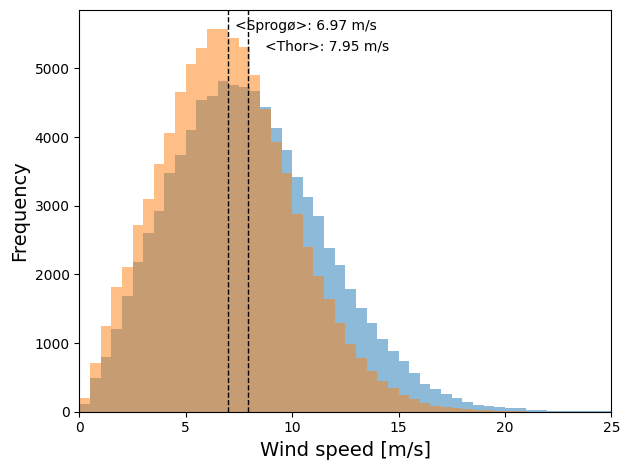

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)

ax.bar(
    binEdges_thor[:-1],
    counts_thor,
    width=np.diff(binEdges_thor),
    edgecolor=None,
    align="edge",
    alpha=0.5,
    label="Thor"
)
ax.bar(
    binEdges_sprogoe[:-1],
    counts_sprogoe,
    width=np.diff(binEdges_sprogoe),
    edgecolor=None,
    align="edge",
    alpha=0.5,
    label="Sprogø"
)
ax.legend()

ax.set_xlabel("Wind speed [m/s]", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

ax.set_xlim(0, 25)
min_ylim, max_ylim = plt.ylim()

plt.axvline(mean_thor, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean_sprogoe, color='k', linestyle='dashed', linewidth=1)

plt.text(
    mean_thor * 1.1,
    max_ylim * 0.9,
    '<Thor>: {:.2f} m/s'.format(mean_thor)
)
plt.text(
    mean_sprogoe * 1.05, max_ylim * 0.95,
    '<Sprogø>: {:.2f} m/s'.format(mean_sprogoe)
)